Loaded pbj_nurse with shape (1325324, 33)
Loaded pbj_non_nurse with shape (1325324, 82)
Loaded qrp_provider with shape (710016, 16)
Loaded nh_survey with shape (44189, 41)
Loaded nh_quality_mds with shape (251464, 23)
Loaded nh_ownership with shape (144651, 13)
Loaded nh_citations with shape (406789, 23)
Columns in pbj_nurse: ['provnum', 'provname', 'city', 'state', 'county_name', 'county_fips', 'cy_qtr', 'workdate', 'mdscensus', 'hrs_rndon', 'hrs_rndon_emp', 'hrs_rndon_ctr', 'hrs_rnadmin', 'hrs_rnadmin_emp', 'hrs_rnadmin_ctr', 'hrs_rn', 'hrs_rn_emp', 'hrs_rn_ctr', 'hrs_lpnadmin', 'hrs_lpnadmin_emp', 'hrs_lpnadmin_ctr', 'hrs_lpn', 'hrs_lpn_emp', 'hrs_lpn_ctr', 'hrs_cna', 'hrs_cna_emp', 'hrs_cna_ctr', 'hrs_natrn', 'hrs_natrn_emp', 'hrs_natrn_ctr', 'hrs_medaide', 'hrs_medaide_emp', 'hrs_medaide_ctr']
CNA records in Q2 2024: 1325324 rows


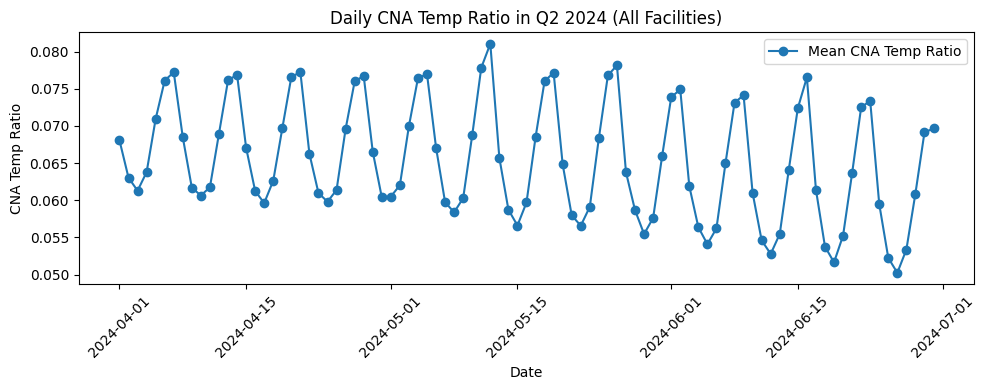

Correlation between daily CNA ratio and resident census: -0.401


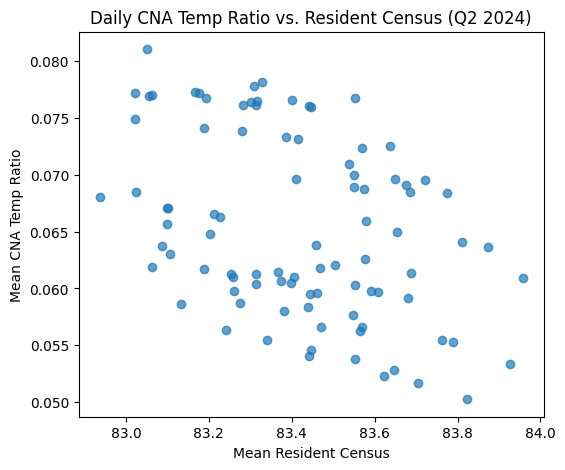

=== CNA Temporary Staffing Ratio Analysis Complete ===


In [1]:
# =========================
# Process Phase - Cell 1: Load Prepared Datasets
# =========================

import os
import pandas as pd

# Define the path where the prepared datasets are stored
PREPARED_PATH = "./data/prepared/"

# Dictionary mapping dataset names to their prepared file names
files = {
    "pbj_nurse": "pbj_nurse_prepared.parquet",
    "pbj_non_nurse": "pbj_non_nurse_prepared.parquet",
    "qrp_provider": "qrp_provider_prepared.parquet",
    "nh_survey": "nh_survey_prepared.parquet",
    "nh_quality_mds": "nh_quality_mds_prepared.parquet",
    "nh_ownership": "nh_ownership_prepared.parquet",
    "nh_citations": "nh_citations_prepared.parquet"
}

loaded_datasets = {}
for key, filename in files.items():
    file_path = os.path.join(PREPARED_PATH, filename)
    try:
        loaded_datasets[key] = pd.read_parquet(file_path)
        print(f"Loaded {key} with shape {loaded_datasets[key].shape}")
    except Exception as e:
        print(f"Error loading {key}: {e}")

# Optionally, check the columns of one dataset to verify
print("Columns in pbj_nurse:", loaded_datasets['pbj_nurse'].columns.tolist())

# =========================
# Process Phase - Cell 2: CNA Temporary Staffing Ratio Analysis
# =========================

import numpy as np
import matplotlib.pyplot as plt

# 1) Copy the PBJ Nurse dataset
df_cna = loaded_datasets['pbj_nurse'].copy()

# 2) Ensure workdate is a proper datetime (if not already)
df_cna['workdate'] = pd.to_datetime(df_cna['workdate'], errors='coerce')

# 3) Define the CNA ratio on a daily basis:
# cna_ratio_d = hrs_cna_ctr_d / (hrs_cna_emp_d + hrs_cna_ctr_d)
required_cols = ['hrs_cna_emp', 'hrs_cna_ctr', 'mdscensus', 'workdate']
if all(c in df_cna.columns for c in required_cols):
    df_cna['cna_temp_ratio'] = df_cna['hrs_cna_ctr'] / (df_cna['hrs_cna_emp'] + df_cna['hrs_cna_ctr'] + 1e-6)
else:
    missing = [c for c in required_cols if c not in df_cna.columns]
    print(f"Missing columns for CNA analysis: {missing}")

# 4) Filter for Q2 2024 (April 1, 2024 through June 30, 2024)
start_date = '2024-04-01'
end_date = '2024-06-30'
mask_q2 = (df_cna['workdate'] >= start_date) & (df_cna['workdate'] <= end_date)
df_cna_q2 = df_cna.loc[mask_q2].copy()

print(f"CNA records in Q2 2024: {len(df_cna_q2)} rows")

# 5) Examine the daily variation in cna_temp_ratio
#    We can group by (provnum, workdate) if needed or just by workdate alone.

# Example A: Simple daily mean ratio across all facilities
daily_trends = (
    df_cna_q2
    .groupby('workdate', as_index=False)
    .agg(
        cna_ratio_mean=('cna_temp_ratio', 'mean'),
        mdscensus_mean=('mdscensus', 'mean')
    )
)

# 6) Plot daily trends
plt.figure(figsize=(10,4))

plt.plot(daily_trends['workdate'], daily_trends['cna_ratio_mean'], marker='o', label='Mean CNA Temp Ratio')
plt.title("Daily CNA Temp Ratio in Q2 2024 (All Facilities)")
plt.xlabel("Date")
plt.ylabel("CNA Temp Ratio")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 7) Examine correlation between cna_ratio_mean and mdscensus_mean
corr_value = daily_trends['cna_ratio_mean'].corr(daily_trends['mdscensus_mean'])
print(f"Correlation between daily CNA ratio and resident census: {corr_value:.3f}")

# Optional: Scatter plot of cna_ratio vs. census
plt.figure(figsize=(6,5))
plt.scatter(daily_trends['mdscensus_mean'], daily_trends['cna_ratio_mean'], alpha=0.7)
plt.title("Daily CNA Temp Ratio vs. Resident Census (Q2 2024)")
plt.xlabel("Mean Resident Census")
plt.ylabel("Mean CNA Temp Ratio")
plt.show()

# Optionally, we can do a facility-level approach:
#   1) Summing/averaging by (provnum, workdate)
#   2) Then grouping or analyzing correlations at the daily or facility level.

# Done!
print("=== CNA Temporary Staffing Ratio Analysis Complete ===")


c:\Users\paulo\OneDrive\TRABALHO\Clipboard Health\clipboard_health_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulo\OneDrive\TRABALHO\Clipboard Health\clipboard_health_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Facility-level correlation with daily census:
      provnum  corr_cna_ratio_census
13782  675364              -0.788390
11955  455817              -0.736778
7152   265706              -0.726113
13644  675032              -0.710500
437    045242              -0.702590
4201   165351              -0.696593
9625   365865              -0.695225
12074  465101              -0.693333
6346   245232              -0.678473
7693   315017              -0.674718
      provnum  corr_cna_ratio_census
14549  686127                    NaN
14550  745000                    NaN
14551  745001                    NaN
14554  745005                    NaN
14555  745006                    NaN
14556  745007                    NaN
14559  745021                    NaN
14560  745022                    NaN
14561  745038                    NaN
14562  745039                    NaN


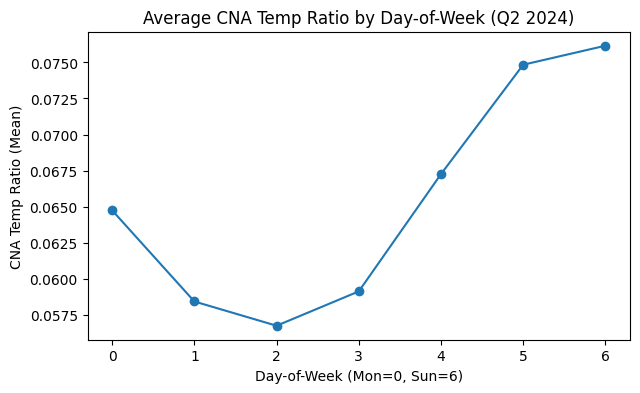

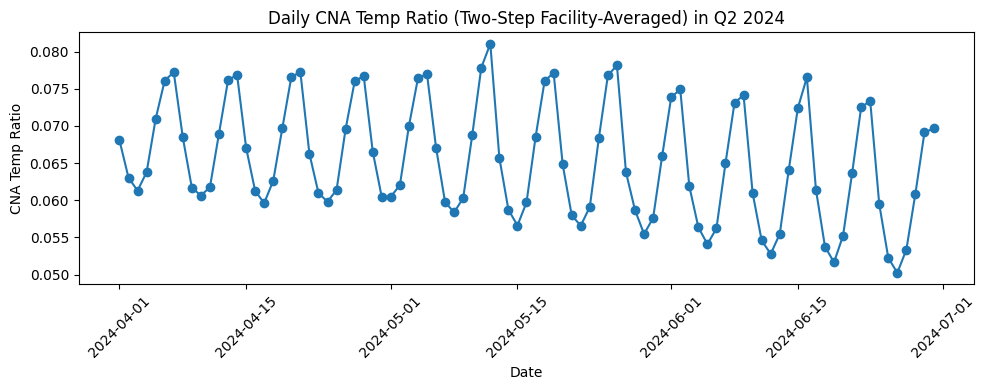

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_cna_q2 is your filtered DataFrame for Q2 2024
# with columns: ['provnum','workdate','hrs_cna_emp','hrs_cna_ctr','mdscensus','cna_temp_ratio']

# 1) FACILITY-LEVEL DAILY VIEW
#    Example: Inspect each facility's daily ratio and see how it correlates with its daily census
df_cna_q2['day_of_week'] = df_cna_q2['workdate'].dt.dayofweek  # Monday=0, Sunday=6

# Group by facility & date, then compute daily ratio and census for that facility
facility_daily = (
    df_cna_q2
    .groupby(['provnum','workdate'], as_index=False)
    .agg(
        daily_cna_ratio=('cna_temp_ratio','mean'),
        daily_census=('mdscensus','mean'),
        day_of_week=('day_of_week','mean')  # or just take any row's day_of_week
    )
)

# Optional: For each facility, compute correlation between daily_cna_ratio and daily_census
facility_correlations = []
for facility_id, subdf in facility_daily.groupby('provnum'):
    if len(subdf) > 5:  # skip tiny facility samples
        corr = subdf['daily_cna_ratio'].corr(subdf['daily_census'])
        facility_correlations.append((facility_id, corr))

# Convert to DataFrame and sort to see which facilities have strong +/- correlations
df_facility_corrs = pd.DataFrame(facility_correlations, columns=['provnum','corr_cna_ratio_census'])
df_facility_corrs.sort_values('corr_cna_ratio_census', inplace=True)
print("Facility-level correlation with daily census:")
print(df_facility_corrs.head(10))   # most negative correlations
print(df_facility_corrs.tail(10))  # most positive correlations

# 2) EXAMINING DAY-OF-WEEK PATTERNS
#    Aggregate by day_of_week across all facilities
dow_stats = (
    facility_daily
    .groupby('day_of_week')
    .agg(
        mean_cna_ratio=('daily_cna_ratio','mean'),
        mean_census=('daily_census','mean')
    )
    .reset_index()
)

# Quick day-of-week plot
plt.figure(figsize=(7,4))
plt.plot(dow_stats['day_of_week'], dow_stats['mean_cna_ratio'], marker='o')
plt.title("Average CNA Temp Ratio by Day-of-Week (Q2 2024)")
plt.xlabel("Day-of-Week (Mon=0, Sun=6)")
plt.ylabel("CNA Temp Ratio (Mean)")
plt.xticks(range(7))
plt.show()

# 3) TWO-STEP AGGREGATION: FACILITY THEN OVERALL
#    Sometimes large facilities can dominate the daily means. Instead, do a daily ratio per facility
#    then average across facilities equally.
#    We already have facility_daily with daily_cna_ratio for each provnum & workdate

day_level_means = (
    facility_daily
    .groupby('workdate', as_index=False)['daily_cna_ratio']
    .mean()   # mean across all facilities (each facility weighted equally)
    .rename(columns={'daily_cna_ratio':'avg_facility_ratio'})
)

# Plot the two-step daily ratio
plt.figure(figsize=(10,4))
plt.plot(day_level_means['workdate'], day_level_means['avg_facility_ratio'], marker='o')
plt.title("Daily CNA Temp Ratio (Two-Step Facility-Averaged) in Q2 2024")
plt.xlabel("Date")
plt.ylabel("CNA Temp Ratio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
